# Project 5 : Application - Twitter Data

## Quesion 1

In [61]:
# Question 1
import pandas as pd
import numpy as np
import json
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import pytz
import random
import pickle

# Question 3
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.regression.linear_model import OLS

random.seed(42)

In [62]:
file_direct = "ECE219_tweet_data/"

def readFromText(file_direct, file_name):
    json_objects = list()
    with open(file_direct + "tweets_#" + str(file_name) + ".txt", "r") as file:
        line = file.readline()
        while line:
            json_objects.append(json.loads(line))
            line = file.readline()
    return json_objects

In [63]:
json_gopatriots = readFromText(file_direct, "gopatriots")
# json_gohawks = readFromText(file_direct, "gohawks")
# json_nfl = readFromText(file_direct, "nfl")
# json_patriots = readFromText(file_direct, "patriots")
# json_sb49 = readFromText(file_direct, "sb49")
# json_superbowl = readFromText(file_direct, "superbowl")



In [64]:
def creationTimeParser(unix_time, time_zone = pytz.timezone('America/Los_Angeles')):
    date_object = datetime.datetime.fromtimestamp(unix_time, time_zone)
    date_object = date_object.replace(minute=0, second=0, microsecond=0)
#     res_val = (date_object.month-1)*31*24+(date_object.day-1)*24+date_object.hour
    return date_object

In [65]:
def getStat(json_objects):
    hr2cnt = dict()
    # Description:
    # Get the the number of tweets, also features forom the tweet
    list_cnt = 0
    total_followers = 0
    total_tweets = 0
    time_zone = pytz.timezone('America/Los_Angeles')
    for i in range(len(json_objects)):
    # parse the avg tweet per hour
        parsed_time = creationTimeParser(json_objects[i]['citation_date'],  time_zone)
        if parsed_time in hr2cnt:
          hr2cnt[parsed_time] += 1
        else:
          hr2cnt[parsed_time] = 1
        total_followers += json_objects[i]['author']['followers']
        total_tweets += json_objects[i]['metrics']['citations']['total']
    hr_np = np.fromiter(hr2cnt.values(), dtype=np.int).reshape((len(hr2cnt),1))
    min_time = min(hr2cnt.keys())
    max_time = max(hr2cnt.keys())
    diff_time = max_time - min_time + timedelta(hours=1)
    avg_tweets = hr_np.sum() / (diff_time.total_seconds()/3600)
    result = {'avg tweets per hour' : avg_tweets, 
          'avg followers per tweet' : total_followers / len(json_objects),
          'avg retweets per tweet' : total_tweets / len(json_objects)}
    print (result)
    return result, hr2cnt

In [66]:
stat_gopatriots, _ = getStat(json_gopatriots)

{'avg tweets per hour': 40.888695652173915, 'avg followers per tweet': 1427.2526051635405, 'avg retweets per tweet': 1.4081919101697078}


## Question 2

In [67]:
#need to load nfl and superbowl data

def getTweetCount(json_objects):
    stat, hr2cnt = getStat(json_objects)
    return hr2cnt
    
def getSortedKeys(hr2cnt):
    keylist = sorted(hr2cnt.keys())
    return keylist

# TODO: change the x ticks to display properly
def generatePlot(hr2cnt, tag_name):
    sorted_time = getSortedKeys(hr2cnt)
    sorted_vals = [hr2cnt[x] for x in sorted_time]
    plt.plot(sorted_time, sorted_vals)
    print("sorted_vals: ", len(sorted_vals))
    plt.xlabel('time')
    plt.ylabel('num of posts')
    plt.title("Tag Name: " + tag_name)
    plt.show()

def Question2(json_objects, tag_name):
    hr2cnt = getTweetCount(json_objects)
    keylist = getSortedKeys(hr2cnt)
    generatePlot(hr2cnt, tag_name)

{'avg tweets per hour': 40.888695652173915, 'avg followers per tweet': 1427.2526051635405, 'avg retweets per tweet': 1.4081919101697078}
sorted_vals:  441


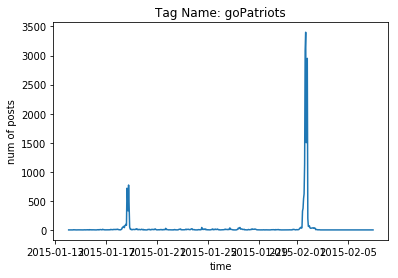

In [68]:
Question2(json_gopatriots, "goPatriots")

## Question 3

In [69]:
def featureExtraction(json_objects):
    hr2feature = dict()
    for i in range(len(json_objects)):
        parsed_time = creationTimeParser(json_objects[i]['citation_date'])
        if parsed_time in hr2feature:
            hr2feature[parsed_time]["num_tweets"] += 1
            hr2feature[parsed_time]["num_retweets"] += json_objects[i]['metrics']['citations']['total']
            hr2feature[parsed_time]["num_followers"] += json_objects[i]['author']['followers']
            hr2feature[parsed_time]["max_followers"] = max(hr2feature[parsed_time]["max_followers"], json_objects[i]['author']['followers'])
        else:
            hr2feature[parsed_time] = dict()
            hr2feature[parsed_time]["hr_of_day"] = parsed_time.hour
            hr2feature[parsed_time]["num_tweets"] = 1
            hr2feature[parsed_time]["num_retweets"] = json_objects[i]['metrics']['citations']['total']
            hr2feature[parsed_time]["num_followers"] = json_objects[i]['author']['followers']
            hr2feature[parsed_time]["max_followers"] = json_objects[i]['author']['followers']
    min_time = min(hr2feature.keys())
    max_time = max(hr2feature.keys())
    hour_time = min_time + timedelta(hours=1)
    while hour_time < max_time:
        if hour_time not in hr2feature:
            hr2feature[hour_time] = dict()
            hr2feature[hour_time]["hr_of_day"] = hour_time.hour
            hr2feature[hour_time]["num_tweets"] = 0
            hr2feature[hour_time]["num_retweets"] = 0
            hr2feature[hour_time]["num_followers"] = 0
            hr2feature[hour_time]["max_followers"] = 0
        hour_time += timedelta(hours=1)
    return hr2feature

feature_list = ['hr_of_day', 'max_followers', 'num_followers', 'num_retweets', 'num_tweets', 'next_num_tweets']

# convert a dictionary to numpy array
def convertDictToNumpy(parsed_features, feature_list):
    df = pd.DataFrame(parsed_features).T.sort_index()
    # create the label column
    df["next_num_tweets"] = df["num_tweets"].shift(-1)
    df = df[feature_list] # reorder the column based on feature
    df.drop(df.tail(1).index, inplace=True)
    train_set = df.values[:,:-1]
    labels = df.values[:,-1]
    labels = labels.reshape((len(labels), 1))
    return {"features" : train_set, "labels" : labels}

def trainAndEvaluate(train_labels_pair):
    # OLS Top three features and P values
    ols = OLS(train_labels_pair["labels"], train_labels_pair["features"])
    res_vals = ols.fit()
    pred_vals = ols.predict(train_labels_pair["labels"])
    # The mean squared error
    print("Mean squared error: %.2f" % mean_squared_error(train_labels_pair["labels"], pred_vals))
    # Explained variance score: 1 is perfect prediction
    print('R2 score: %.2f' % r2_score(y_test, y_pred))

    # OLS Top three features and P values
    ols = OLS(train_labels_pair["labels"], train_labels_pair["features"])
    res_vals = ols.fit()
    print("P values: ", res_vals.pvalues)
    idx_pvals_pair = list()
    for i in range(res_vals.pvalues.shape[0]):
        pair = (res_vals.pvalues[i], i)
        idx_pvals_pair.append(pair)
    idx_pvals_pair = sorted(idx_pvals_pair, key=lambda x:x[0])
    print("Top three features")
    for i in range(3):
        print("feature:", feature_list[idx_pvals_pair[i][1]], ", P value:", idx_pvals_pair[i][0])
    print ("summary: ", res_vals.summary())
    return

In [70]:
parsed_features = featureExtraction(json_gopatriots)
train_labels_pair = convertDictToNumpy(parsed_features, feature_list)
trainAndEvaluate(train_labels_pair)

ValueError: shapes (574,5) and (574,1) not aligned: 5 (dim 1) != 574 (dim 0)